In [1]:
# -*- coding: utf-8 -*-
from __future__ import division, print_function
import collections
import os

import nltk
import numpy as np
from keras.layers import Activation, Dense, Dropout, RepeatVector, Embedding, \
    GRU, LSTM, TimeDistributed, Bidirectional
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
# 文章から、単語の頻出度、最大長、行数を抽出
def parse_sentences(filename):
    word_freqs = collections.Counter()
    num_recs, maxlen = 0, 0
    with open(filename, "r") as fin:
        for line in fin:
            words = line.strip().lower().split()
            for word in words:
                word_freqs[word] += 1
            maxlen = max(maxlen, len(words))
            num_recs += 1
    return word_freqs, maxlen, num_recs

In [3]:
# 文章とルックアップテーブルから、入力データ（ numrecs * 250）を生成
def build_tensor(filename, numrecs, word2index, maxlen):
    data = np.empty((numrecs, ), dtype=list)
    with open(filename, "r") as fin:
        for i, line in enumerate(fin):
            wids = []
            for word in line.strip().lower().split():
                if word in word2index:
                    wids.append(word2index[word])
                else:
                    wids.append(word2index["UNK"])
            data[i] = wids
    pdata = sequence.pad_sequences(data, maxlen=maxlen)
    return pdata

In [4]:
DATA_DIR = "./data"

In [5]:
with open(os.path.join(DATA_DIR, "treebank_sents.txt"), "w") as fedata, \
        open(os.path.join(DATA_DIR, "treebank_poss.txt"), "w") as ffdata:
    sents = nltk.corpus.treebank.tagged_sents()
    for sent in sents:
        words, poss = [], []
        for word, pos in sent:
            if pos == "-NONE-":
                continue
            words.append(word)
            poss.append(pos)
        fedata.write("{:s}\n".format(" ".join(words)))
        ffdata.write("{:s}\n".format(" ".join(poss)))

In [6]:
s_wordfreqs, s_maxlen, s_numrecs = \
    parse_sentences(os.path.join(DATA_DIR, "treebank_sents.txt"))
t_wordfreqs, t_maxlen, t_numrecs = \
    parse_sentences(os.path.join(DATA_DIR, "treebank_poss.txt"))
print("# records: {:d}".format(s_numrecs))
print("# unique words: {:d}".format(len(s_wordfreqs)))
print("# unique POS tags: {:d}".format(len(t_wordfreqs)))
print("# words/sentence: max: {:d}".format(s_maxlen))

# records: 3914
# unique words: 10947
# unique POS tags: 45
# words/sentence: max: 249


In [7]:
MAX_SEQLEN = 250
S_MAX_FEATURES = 5000
T_MAX_FEATURES = 45

In [8]:
# 1 is UNK, 0 is PAD
# 語彙数を5002後に設定(※UNKとPAD含む)
# ルックアップテーブルの生成
s_vocabsize = min(len(s_wordfreqs), S_MAX_FEATURES) + 2
s_word2index = {x[0]: i+2 for i, x in
                enumerate(s_wordfreqs.most_common(S_MAX_FEATURES))}
s_word2index["PAD"] = 0
s_word2index["UNK"] = 1
s_index2word = {v: k for k, v in s_word2index.items()}

# ラベルについては、語彙数を減らしてないためUNKを含める必要はない
# ルックアップテーブルの生成
t_vocabsize = len(t_wordfreqs) + 1
t_word2index = {x[0]: i for i, x in
                enumerate(t_wordfreqs.most_common(T_MAX_FEATURES))}
t_word2index["PAD"] = 0
t_index2word = {v: k for k, v in t_word2index.items()}

In [9]:
X = build_tensor(os.path.join(DATA_DIR, "treebank_sents.txt"),
                 s_numrecs, s_word2index, MAX_SEQLEN)
Y = build_tensor(os.path.join(DATA_DIR, "treebank_poss.txt"),
                 t_numrecs, t_word2index, MAX_SEQLEN)
Y = np.array([np_utils.to_categorical(d, t_vocabsize) for d in Y])
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y,
                                                test_size=0.2, random_state=42)

In [10]:
EMBED_SIZE = 128
HIDDEN_SIZE = 64
BATCH_SIZE = 32
NUM_EPOCHS = 1

In [11]:
# GRU
model = Sequential()
model.add(Embedding(s_vocabsize, EMBED_SIZE, input_length=MAX_SEQLEN))
model.add(Dropout(0.2))
model.add(GRU(HIDDEN_SIZE, dropout=0.2, recurrent_dropout=0.2))
model.add(RepeatVector(MAX_SEQLEN))
model.add(GRU(HIDDEN_SIZE, return_sequences=True))
model.add(TimeDistributed(Dense(t_vocabsize)))
model.add(Activation("softmax"))
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

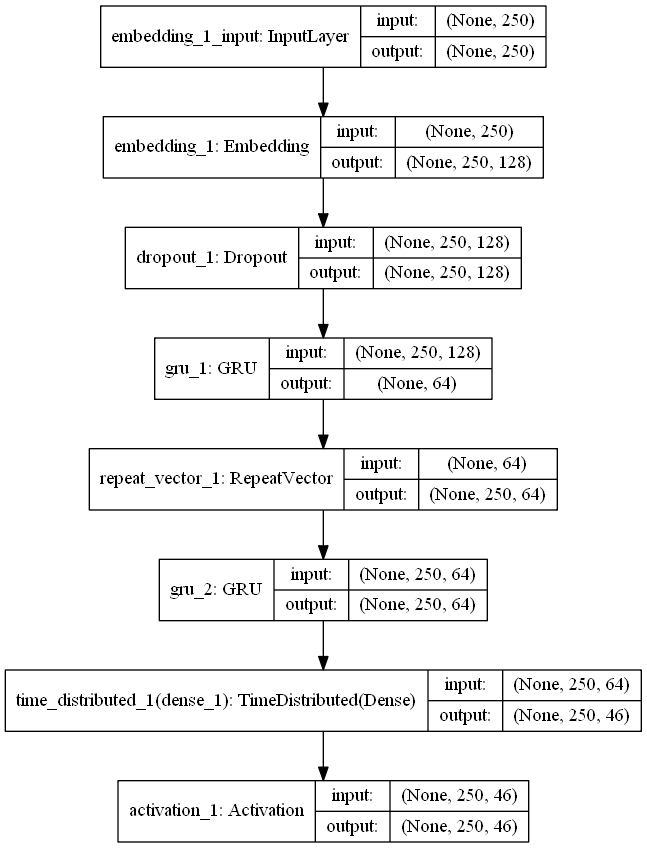

In [12]:
from keras.utils import plot_model
plot_model(model, to_file='./model.png', show_shapes='t')

In [13]:
model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE,
          epochs=NUM_EPOCHS, validation_data=[Xtest, Ytest])
score, acc = model.evaluate(Xtest, Ytest, batch_size=BATCH_SIZE)
print("Test score: {:.3f}, accuracy: {:.3f}".format(score, acc))

d:\python_projects\ml_study_projects\tf_gpu\.venv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3131 samples, validate on 783 samples
Epoch 1/1
783/783 [==============================] - 6s 8ms/step
Test score: 0.564, accuracy: 0.916


In [14]:
## 予測してみる
text_arr = [
        "Terms were n't disclosed .",
        "Trinity said it plans to begin delivery in the first quarter of next year .",
        "`` There were so many economic reports but the market did n't care about any of them , '' said Kathleen Camilli , a money market economist at Drexel Burnham Lambert Inc ."
       ]
print(text_arr)

["Terms were n't disclosed .", 'Trinity said it plans to begin delivery in the first quarter of next year .', "`` There were so many economic reports but the market did n't care about any of them , '' said Kathleen Camilli , a money market economist at Drexel Burnham Lambert Inc ."]


In [15]:

data =  np.empty((len(text_arr), ), dtype=list)
for i, text in enumerate(text_arr):
    wids = []
    for word in text.strip().lower().split():
        if word in s_word2index:
            wids.append(s_word2index[word])
        else:
            wids.append(s_word2index["UNK"])

    data[i] = wids
pdata = sequence.pad_sequences(data, maxlen=MAX_SEQLEN)
print(pdata)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0   

In [16]:
predict = model.predict(pdata)
pos = np.empty((len(pdata), 250))
for i, pre in enumerate(predict):
    for j, idx in enumerate(pre):
        pos[i][j] =  np.argmax(idx)

print(pos)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 

In [17]:
res = [[""] * 250] * len(pdata)
for i, po in enumerate(pos):
    for j, p in enumerate(po):
        res[i][j] =  t_index2word[p]
print(res)

[['PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD